# **1. Import Library**

In [1]:
# !pip install tensorflow_recommenders

In [2]:
# !pip install tensorflow==2.15.0

In [3]:
# !pip install keras-tuner

In [4]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  0


In [5]:
# Standard Libraries
import os
import time
import random
import pickle
from collections import Counter

# Seed Setup
import numpy as np
np.random.seed(0)  # Set seed sebelum pengacakan

# Data Manipulation & Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# Deep Learning & Modeling
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Optional / Custom Libraries
import kagglehub

# Pandas Configuration
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# Warnings Configuration
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Load Dataset**

In [8]:
mainPath =  '/content/drive/MyDrive/Colab Notebooks/Capstone - Course Recommender Systems/' # Path of the main project
dataPath = os.path.join(mainPath, 'Dataset/') # Path of the dataset

In [9]:
# Load the CSV file from the URL
df_courses = pd.read_csv(dataPath + 'udemy_courses_new.csv')
df_interactions = pd.read_csv(dataPath + 'synthetic_user_interactions.csv')

In [10]:
df_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3672 non-null   int64  
 1   course_title         3672 non-null   object 
 2   url                  3672 non-null   object 
 3   is_paid              3672 non-null   bool   
 4   price                3672 non-null   int64  
 5   num_subscribers      3672 non-null   int64  
 6   num_reviews          3672 non-null   int64  
 7   num_lectures         3672 non-null   int64  
 8   level                3672 non-null   object 
 9   content_duration     3672 non-null   float64
 10  published_timestamp  3672 non-null   object 
 11  subject              3672 non-null   object 
 12  total_interactions   3672 non-null   int64  
 13  total_users          3672 non-null   int64  
dtypes: bool(1), float64(1), int64(7), object(5)
memory usage: 376.7+ KB


In [11]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109329 entries, 0 to 109328
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           109329 non-null  object
 1   course_id         109329 non-null  int64 
 2   interaction_type  109329 non-null  object
 3   interaction       109329 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


In [12]:
df_courses.head(2)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,total_interactions,total_users
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5000,2017-01-18T20:58:58Z,Business Finance,10,10
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0000,2017-03-09T16:34:20Z,Business Finance,15,14


In [13]:
df_interactions.sample(2)

,user_id,course_id,interaction_type,interaction
108585,user_124,1248172,view,1
27373,user_81,941310,enrolled,1


In [14]:
df_interactions.groupby(["user_id", "interaction_type"])[["interaction"]].sum()

interaction
user_id interaction_type             
user_1  buy                        47
        complete                   27
        enrolled                   49
        view                      122
user_10 buy                        51
...                               ...
user_98 view                      107
user_99 buy                        50
        complete                   26
        enrolled                   43
        view                      126

[2000 rows x 1 columns]

# **3. Recommenders Modeling - [Collaborative Filtering]**

## **3.1 Preprocessing data**

In [15]:
# Karena TFRS biasanya pakai string, pastikan course_id dan user_id jadi string
df_interactions['user_id'] = df_interactions['user_id'].astype(str)
df_interactions['course_id'] = df_interactions['course_id'].astype(str)

# Ambil list unik user dan course
user_ids = sorted(df_interactions['user_id'].unique().tolist())
course_ids = sorted(df_interactions['course_id'].unique().tolist())

### **3.1.1 Leave-K-Out Split (Train/Test)**

In [16]:
# Fungsi Split per user --- (k interaksi terakhir jadi test) ---
def leave_last_k_out_split(df, user_col='user_id', sort_col=None, k=10):
    """
    Split data jadi train & test, ambil k interaksi terakhir per user jadi test.
    Jika user punya kurang dari k interaksi, semua interaksi masuk test.
    """
    df = df.copy()
    if sort_col:
        df = df.sort_values([user_col, sort_col])
    # Simpan index test interaksi
    test_idxs = []

    # Group per user
    for user, group in df.groupby(user_col):
        n_interactions = len(group)
        # Kalau interaksi user kurang dari k, ambil semua test
        if n_interactions <= k:
            test_idxs.extend(group.index.tolist())
        else:
            test_idxs.extend(group.tail(k).index.tolist())

    df_test = df.loc[test_idxs]
    df_train = df.drop(index=test_idxs)

    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [17]:
# 🧪 Terapkan split pada df_interactions
df_train, df_test = leave_last_k_out_split(df_interactions, k=20)

In [18]:
# 🔢 Tampilkan ringkasan jumlah data
print(f"\n📊 Jumlah interaksi total     : {len(df_interactions)}")
print(f"🧪 Jumlah interaksi di TRAIN  : {len(df_train)} - {(len(df_train) / len(df_interactions) * 100):.2f}%")
print(f"🧪 Jumlah interaksi di TEST   : {len(df_test)} - {(len(df_test) / len(df_interactions) * 100):.2f}%")
print(f"👤 Jumlah user unik           : {df_interactions['user_id'].nunique()}")
print(f"🧩 Perbandingan train/test    : {len(df_train)} / {len(df_test)}")


📊 Jumlah interaksi total     : 109329
🧪 Jumlah interaksi di TRAIN  : 99329 - 90.85%
🧪 Jumlah interaksi di TEST   : 10000 - 9.15%
👤 Jumlah user unik           : 500
🧩 Perbandingan train/test    : 99329 / 10000


In [19]:
# 📊 Visualisasi distribusi jumlah interaksi per user (train vs test)
user_counts_train = df_train['user_id'].value_counts()
user_counts_test = df_test['user_id'].value_counts()

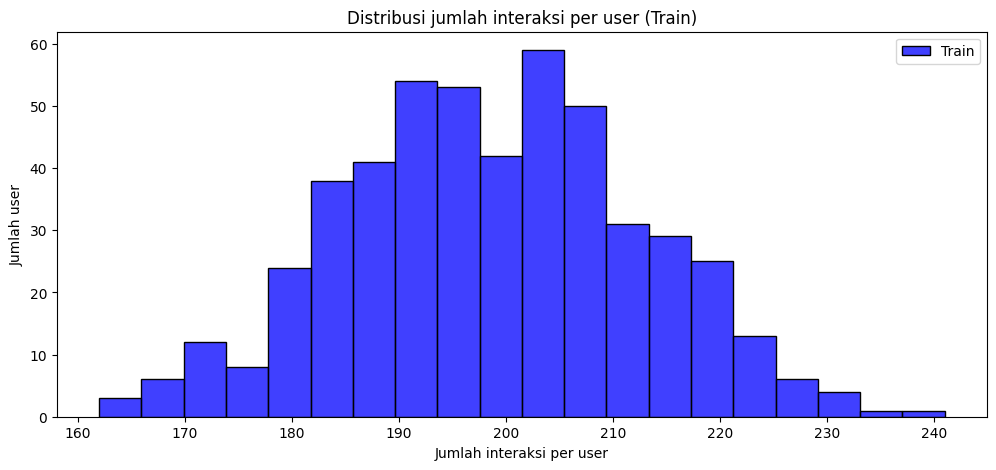

In [20]:
plt.figure(figsize=(12,5))
sns.histplot(user_counts_train, bins=20, kde=False, color='blue', label='Train')
plt.title("Distribusi jumlah interaksi per user (Train)")
plt.xlabel("Jumlah interaksi per user")
plt.ylabel("Jumlah user")
plt.legend()
plt.show()

### **3.1.2 Buat tf.data.Dataset dari Train/Test Split**

In [21]:
# Membuat dataset training dari kolom user_id dan course_id di df_train
train_ds = tf.data.Dataset.from_tensor_slices({
    'user_id': df_train['user_id'].values, # Ambil array user_id dari data train
    'course_id': df_train['course_id'].values # Ambil array course_id dari data train
}).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
# Acak data dengan buffer 1000 untuk mencegah model belajar urutan data
# Bagi dataset menjadi batch berukuran 128 untuk training efisien
# Load batch berikutnya secara asynchronous saat evaluasi


# Membuat dataset testing dari kolom user_id dan course_id di df_test
test_ds = tf.data.Dataset.from_tensor_slices({
    'user_id': df_test['user_id'].values,
    'course_id': df_test['course_id'].values
}).batch(128).prefetch(tf.data.AUTOTUNE)

In [22]:
# Checking train Dataset after
for batch in train_ds.take(1): # artinya AMBIL 1 BATCH, bukan 1 data
    batch_user_ids = batch['user_id'].numpy()
    batch_course_ids = batch['course_id'].numpy()

    for uid, cid in zip(batch_user_ids, batch_course_ids):
        print(f"user_id: {uid.decode() if isinstance(uid, bytes) else uid}, course_id: {cid.decode()}")

# ⚠️ Catatan penting: karena df_interactions['user_id'] isinya string (user_123), TensorFlow akan menyimpannya sebagai bytes di dataset. Jadi kalau kamu lihat hasilnya, user_id bisa muncul seperti:

user_id: user_451, course_id: 1011058
user_id: user_57, course_id: 1246208
user_id: user_450, course_id: 739964
user_id: user_112, course_id: 948974
user_id: user_286, course_id: 859742
user_id: user_12, course_id: 1246208
user_id: user_289, course_id: 1113822
user_id: user_209, course_id: 353044
user_id: user_210, course_id: 504036
user_id: user_468, course_id: 380970
user_id: user_414, course_id: 564966
user_id: user_130, course_id: 606928
user_id: user_359, course_id: 1006314
user_id: user_442, course_id: 1196544
user_id: user_162, course_id: 975046
user_id: user_418, course_id: 719698
user_id: user_104, course_id: 831066
user_id: user_254, course_id: 380970
user_id: user_419, course_id: 1210588
user_id: user_170, course_id: 975046
user_id: user_80, course_id: 1196544
user_id: user_209, course_id: 447362
user_id: user_12, course_id: 1266306
user_id: user_462, course_id: 1210588
user_id: user_325, course_id: 564966
user_id: user_274, course_id: 58977
user_id: user_396, course_id: 564

## **3.2 Inisialisasi Model Collaborative Filtering**

In [23]:
class CourseModel(tfrs.Model):
    def __init__(self, user_vocab, course_vocab, embedding_dim=64):
        super().__init__()
        # ... (inisialisasi user_vocab, course_vocab, embedding_dim)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # ... (inisialisasi user_model, course_model, task)

    def call(self, features):
        # ... (forward pass)
        pass

    def get_config(self):
        # ...
        pass

    @classmethod
    def from_config(cls, config):
        # ...
        pass

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features['user_id'])
        course_embeddings = self.course_model(features['course_id'])
        loss = self.task(user_embeddings, course_embeddings)
        self.total_loss_tracker.update_state(loss)
        return loss

    # ============================================
    # 📊 metrics - PERBAIKAN DI SINI!
    # Ubah ini menjadi properti agar bisa di-iterasi oleh Keras
    # ============================================
    @property # Tambahkan dekorator ini!
    def metrics(self):
        # Pastikan ini mengembalikan daftar objek metrik
        # Termasuk metrik dari TFRS task jika kamu ingin juga dimonitor secara langsung oleh Keras
        return [self.total_loss_tracker] + self.task.metrics # self.task.metrics sudah list

In [24]:
# ⬇️ Inherit dari TFRS (TensorFlow Recommenders)
class CourseModel(tfrs.Model):
    def __init__(self, user_vocab, course_vocab, embedding_dim=64):
        super().__init__()

        # ================================
        # Simpan parameter sebagai atribut
        # Penting untuk get_config agar bisa serialisasi dengan benar
        # ================================
        self.user_vocab = user_vocab
        self.course_vocab = course_vocab
        self.embedding_dim = embedding_dim

        # Tambahkan metrik total_loss eksplisit
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # ================================
        # 🏛 USER TOWER
        # Ubah user_id (string) ➜ index ➜ embedding
        # ================================
        self.user_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=user_vocab,   # daftar semua user_id
                mask_token=None          # tidak pakai token khusus untuk "kosong"
            ),
            tf.keras.layers.Embedding(
                input_dim=len(user_vocab) + 1,
                output_dim=embedding_dim
            )
        ])

        # ================================
        # 🏫 COURSE TOWER
        # Ubah course_id (string) ➜ index ➜ embedding
        # ================================
        self.course_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=course_vocab,
                mask_token=None
            ),
            tf.keras.layers.Embedding(
                input_dim=len(course_vocab) + 1,
                output_dim=embedding_dim
            )
        ])

        # =======================================
        # 🎯 RETRIEVAL TASK (dengan evaluasi Top-K)
        # Tujuannya adalah: buat user dan course relevan
        # saling mendekat di ruang embedding
        # =======================================
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tf.data.Dataset.from_tensor_slices(course_vocab)
                    .batch(128)
                    .map(self.course_model)  # konversi course_id ➜ embedding
            )
        )

    # ============================================
    # 🚀 call
    # Definisi forward pass model
    # Input: fitur berisi 'user_id' dan 'course_id'
    # Output: embedding vektor untuk user dan course
    # Dipakai saat inference dan saat menyimpan model
    # ============================================
    def call(self, features):
        user_embeddings = self.user_model(features['user_id'])
        course_embeddings = self.course_model(features['course_id'])
        return user_embeddings, course_embeddings

    # ============================================
    # ⚙️ get_config
    # Mengembalikan konfigurasi model dalam bentuk dictionary
    # Konfigurasi ini berisi parameter penting untuk membangun ulang model
    # Berguna untuk menyimpan dan memuat model subclass dengan benar
    # ============================================
    def get_config(self):
        return {
            'user_vocab': self.user_vocab,
            'course_vocab': self.course_vocab,
            'embedding_dim': self.embedding_dim
        }

    # ============================================
    # 🏗️ from_config (classmethod)
    # Membuat instance model baru dari konfigurasi yang disimpan
    # Memungkinkan reconstruct model dengan parameter yang sama saat loading
    # ============================================
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    # ============================================
    # 🔁 compute_loss
    # Fungsi utama saat training untuk menghitung loss
    # input = features['user_id'] dan ['course_id']
    # output = loss dari user-course pairs
    # ============================================
    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features['user_id'])
        course_embeddings = self.course_model(features['course_id'])
        loss = self.task(user_embeddings, course_embeddings)
        self.total_loss_tracker.update_state(loss)
        return loss

    # ============================================
    # 📊 metrics
    # properti agar total_loss dikenali sebagai metrik oleh callback dan bisa di-iterasi oleh Keras
    # ============================================
    @property # Tambahkan dekorator ini!
    def metrics(self):
        # Pastikan ini mengembalikan daftar objek metrik
        # Termasuk metrik dari TFRS task jika kamu ingin juga dimonitor secara langsung oleh Keras
        return [self.total_loss_tracker] + self.task.metrics # self.task.metrics sudah list

# Struktur model ini disebut two-tower model:
# 🏛 User tower → encode user_id ke vektor
# 🏫 Course tower → encode course_id ke vektor
# 🎯 Retrieval task → belajar membuat user dan course cocok berada dekat dalam ruang vektor

## **3.3 Build Model for Tuning**

In [25]:
# Fungsi build_model tetap sama seperti yang sudah dimodifikasi untuk tuning optimizer
def build_model(hp):
    embedding_dim = hp.Int(
        'embedding_dim',
        min_value=32,
        max_value=128,
        step=32
    )
    learning_rate = hp.Choice(
        'learning_rate',
        values=[1e-2, 1e-3, 1e-4]
    )
    optimizer_name = hp.Choice(
        'optimizer',
        values=['adagrad', 'adam']
    )

    model = CourseModel(
        user_vocab=user_ids,
        course_vocab=course_ids,
        embedding_dim=embedding_dim
    )

    if optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer
    )
    return model

## **3.4 Define Callbacks for Training Model**

In [26]:
# --- Definisi Path Model to save all about modelling ---
modelPath1 = os.path.join(mainPath, 'Model/1. Collaborative Filtering/')
os.makedirs(modelPath1, exist_ok=True)

In [27]:
# 📛 1. EarlyStopping: Berhenti otomatis jika tidak ada perbaikan loss selama beberapa epoch
early_stop = EarlyStopping(
    monitor='loss',              # Pantau training total_loss
    patience=3,                  # Tunggu 3 epoch tanpa peningkatan sebelum stop
    restore_best_weights=True,   # Kembalikan bobot ke versi terbaik
    verbose=1                    # Tampilkan info when the callback takes an action.
)

# 🔽 2. ReduceLROnPlateau: Turunkan learning rate jika model stagnan
lr_reducer = ReduceLROnPlateau(
    monitor='loss',     # Pantau training loss
    factor=0.5,         # Turunkan learning rate jadi setengah
    patience=3,         # Kalau 3 epoch ga membaik, baru turunkan lr
    verbose=1           # Print info saat lr berubah
)

# 💾 3. ModelCheckpoint: Simpan model terbaik selama training
checkpoint = ModelCheckpoint(
    filepath= os.path.join(modelPath1, 'best_model_tuned_bayesian.keras'),  # Path file hasil simpan
    monitor='loss',                          # Pantau training loss
    save_best_only=True,                     # Simpan hanya jika lebih baik
    save_weights_only=False,                 # Simpan seluruh model (bukan hanya weights)
    verbose=1                                # Tampilkan info saat menyimpan
)

In [28]:
# --- Menggunakan kt.BayesianOptimization ---
print("\n🔍 Memulai pencarian hyperparameter dengan Bayesian Optimization...")
tuner = kt.BayesianOptimization(
    build_model,                                     # Fungsi yang membangun model kita
    objective=kt.Objective("loss", direction="min"), # Metrik yang ingin kita optimalkan (minimalkan)
    max_trials=10,                                   # Jumlah total percobaan yang akan dilakukan Tuner
                                                     # Disarankan meningkatkan ini untuk Bayesian Optimization
    executions_per_trial=1,                          # Berapa kali setiap kombinasi di-run
    directory= modelPath1 + 'keras_tuner_dir_bayesian', # Direktori baru untuk hasil Bayesian Optimization
    project_name='collaborative_filtering_tuning', # Nama project baru
    overwrite=True                                   # Jika direktori sudah ada, timpa saja
)

# ⏱️ Mulai hitung waktu
start_time = time.time()

# --- Mulai Pencarian Hyperparameter ---
tuner.search(
    train_ds,
    epochs=25, # Jumlah epoch per trial
    callbacks=[early_stop, lr_reducer, checkpoint], # Gunakan callbacks saat tuning
    # validation_data=test_ds # Opsional
)

# ⏱️ Selesai, hitung durasi
end_time = time.time()
elapsed_time = end_time - start_time

Trial 10 Complete [00h 08m 25s]
loss: 0.0

Best loss So Far: 0.0
Total elapsed time: 01h 24m 31s


In [29]:
# 🕒 Tampilkan waktu dalam format yang ramah dibaca
minutes, seconds = divmod(elapsed_time, 60)
print("\n✅ Pencarian hyperparameter dengan Bayesian Optimization selesai.")
print(f"\n⏱️ Training selesai dalam {int(minutes)} menit {int(seconds)} detik.")


✅ Pencarian hyperparameter dengan Bayesian Optimization selesai.

⏱️ Training selesai dalam 84 menit 31 detik.


In [30]:
# Ambil ringkasan dari semua trial
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/Capstone - Course Recommender Systems/Model/1. Collaborative Filtering/keras_tuner_dir_bayesian/collaborative_filtering_tuning
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 00 summary
Hyperparameters:
embedding_dim: 128
learning_rate: 0.0001
optimizer: adam
Score: 0.0

Trial 01 summary
Hyperparameters:
embedding_dim: 32
learning_rate: 0.0001
optimizer: adam
Score: 0.0

Trial 02 summary
Hyperparameters:
embedding_dim: 64
learning_rate: 0.01
optimizer: adagrad
Score: 0.0

Trial 03 summary
Hyperparameters:
embedding_dim: 32
learning_rate: 0.01
optimizer: adam
Score: 0.0

Trial 04 summary
Hyperparameters:
embedding_dim: 96
learning_rate: 0.01
optimizer: adam
Score: 0.0

Trial 05 summary
Hyperparameters:
embedding_dim: 96
learning_rate: 0.001
optimizer: adagrad
Score: 0.0

Trial 06 summary
Hyperparameters:
embedding_dim: 64
learning_rate: 0.0001
optimizer: adagrad
Score: 0.0

Trial 07 summary
Hyperpara

In [31]:
# Ambil semua trial yang telah dijalankan
all_trials = tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials)

print(f"\nTotal trials completed: {len(all_trials)}")
print("\nDetail dari setiap trial:")
for i, trial in enumerate(all_trials):
    print(f"\n--- Trial {i+1} (ID: {trial.trial_id}) ---")
    print(f"Status: {trial.status}")
    print(f"Score (total_loss): {trial.score:.4f}")
    print("Hyperparameters:")
    for hp_name, hp_value in trial.hyperparameters.values.items():
        print(f"  {hp_name}: {hp_value}")


Total trials completed: 10

Detail dari setiap trial:

--- Trial 1 (ID: 00) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 128
  learning_rate: 0.0001
  optimizer: adam

--- Trial 2 (ID: 01) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 32
  learning_rate: 0.0001
  optimizer: adam

--- Trial 3 (ID: 02) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 64
  learning_rate: 0.01
  optimizer: adagrad

--- Trial 4 (ID: 03) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 32
  learning_rate: 0.01
  optimizer: adam

--- Trial 5 (ID: 04) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 96
  learning_rate: 0.01
  optimizer: adam

--- Trial 6 (ID: 05) ---
Status: COMPLETED
Score (total_loss): 0.0000
Hyperparameters:
  embedding_dim: 96
  learning_rate: 0.001
  optimizer: adagrad

--- Trial 7 (ID: 06) ---
Status: COMPLETED
S

In [32]:
# --- Mendapatkan Model Terbaik ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\n✨ Hyperparameter terbaik ditemukan:")
print(f"  - Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"  - Learning Rate: {best_hps.get('learning_rate')}")
print(f"  - Optimizer: {best_hps.get('optimizer')}")

# Bangun model terbaik menggunakan hyperparameter terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\n🚀 Model terbaik berhasil dimuat.")


✨ Hyperparameter terbaik ditemukan:
  - Embedding Dimension: 128
  - Learning Rate: 0.0001
  - Optimizer: adam

🚀 Model terbaik berhasil dimuat.


In [33]:
# Kamu bisa melanjutkan dengan evaluasi best_model ini
# Misalnya, menjalankan model.evaluate() pada test_ds jika kamu menambahkan validation_data
print("\n📊 Evaluasi model terbaik pada test dataset:")
eval_results = best_model.evaluate(test_ds, return_dict=True)
print(f"Loss pada test set: {eval_results['loss']:.4f}")
for metric_name, metric_value in eval_results.items():
    if 'factorized_top_k' in metric_name:
        print(f"{metric_name}: {metric_value:.4f}")


📊 Evaluasi model terbaik pada test dataset:
79/79 [==============================] - 10s 121ms/step - total_loss: 44.3625 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0011 - factorized_top_k/top_10_categorical_accuracy: 0.0029 - factorized_top_k/top_50_categorical_accuracy: 0.0153 - factorized_top_k/top_100_categorical_accuracy: 0.0294 - loss: 606.6555 - regularization_loss: 0.0000e+00
Loss pada test set: 44.3625
factorized_top_k/top_1_categorical_accuracy: 0.0001
factorized_top_k/top_5_categorical_accuracy: 0.0011
factorized_top_k/top_10_categorical_accuracy: 0.0029
factorized_top_k/top_50_categorical_accuracy: 0.0153
factorized_top_k/top_100_categorical_accuracy: 0.0294


In [34]:
tuning_dir = tuner.directory
project_name = tuner.project_name
full_path = os.path.join(tuning_dir, project_name)
print(f"\nDirektori hasil tuning: {full_path}")
print(f"Isi direktori: {os.listdir(full_path)}")


Direktori hasil tuning: /content/drive/MyDrive/Colab Notebooks/Capstone - Course Recommender Systems/Model/1. Collaborative Filtering/keras_tuner_dir_bayesian/collaborative_filtering_tuning
Isi direktori: ['trial_00', 'oracle.json', 'tuner0.json', 'trial_01', 'trial_02', 'trial_03', 'trial_04', 'trial_05', 'trial_06', 'trial_07', 'trial_08', 'trial_09']


## **3.6 Evaluasi Metric for the Model**

**evaluasi dan metrik** dalam **sistem rekomendasi** (retrieval model seperti TFRS).

📊 METRIK UMUM DALAM SISTEM REKOMENDASI (TFRS)

| Metrik                         | Penjelasan                                                             |
| ------------------------------ | ---------------------------------------------------------------------- |
| **Recall\@K**                  | Dari semua item relevan, berapa banyak yang berhasil direkomendasikan? |
| **Precision\@K**               | Dari semua rekomendasi, berapa yang benar-benar relevan?               |
| **Top-K Accuracy**             | Apakah item yang benar muncul di top-K rekomendasi?                    |
| **NDCG**                       | Apakah ranking item relevan cukup tinggi? (Normalized Discounted Gain) |
| **Mean Reciprocal Rank (MRR)** | Ranking seberapa cepat item relevan muncul                             |

> TFRS saat ini paling umum pakai **`Recall@K` (via `FactorizedTopK`)** sebagai metrik utama.

In [35]:
# Evaluasi model di test set
results = best_model.evaluate(test_ds, return_dict=True)

print("\n📈 Evaluation Metrics (Test Data):")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")

79/79 [==============================] - 11s 137ms/step - total_loss: 44.3625 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0011 - factorized_top_k/top_10_categorical_accuracy: 0.0029 - factorized_top_k/top_50_categorical_accuracy: 0.0153 - factorized_top_k/top_100_categorical_accuracy: 0.0294 - loss: 606.6555 - regularization_loss: 0.0000e+00

📈 Evaluation Metrics (Test Data):
total_loss: 44.3625
factorized_top_k/top_1_categorical_accuracy: 0.0001
factorized_top_k/top_5_categorical_accuracy: 0.0011
factorized_top_k/top_10_categorical_accuracy: 0.0029
factorized_top_k/top_50_categorical_accuracy: 0.0153
factorized_top_k/top_100_categorical_accuracy: 0.0294
loss: 44.3625
regularization_loss: 0.0000


In [36]:
# Buat index yang digunakan sebagai search/retrieval untuk rekomendasi awal
index = tfrs.layers.factorized_top_k.BruteForce(best_model.user_model)

# Hubungkan dengan course tower (item embedding)
index.index_from_dataset(
    tf.data.Dataset.from_tensor_slices(course_ids).batch(128).map(lambda cid: (cid, best_model.course_model(cid)))
)

In [37]:
# Siapkan test set sebagai dictionary: {user_id: course_id}
user_true_items = dict(zip(df_test['user_id'], df_test['course_id']))

K = 10  # top-K recommendation

# Simpan hasil evaluasi
recall_total, precision_total, ndcg_total, mrr_total, hit_total = 0, 0, 0, 0, 0
total_users = 0

for user_id, true_item in user_true_items.items():
    # Ambil top-K rekomendasi untuk user ini
    scores, recommended_courses = index(tf.constant([user_id]), k=K)
    recommended_courses = [cid.numpy().decode() for cid in recommended_courses[0]]

    # Apakah item ground truth ada di top-K?
    if true_item in recommended_courses:
        hit_total += 1
        rank = recommended_courses.index(true_item)
        recall_total += 1     # hanya 1 item relevan per user
        precision_total += 1 / K
        mrr_total += 1 / (rank + 1)
        ndcg_total += 1 / np.log2(rank + 2)
    total_users += 1

In [38]:
# Hitung metrik akhir
recall_at_k = recall_total / total_users
precision_at_k = precision_total / total_users
topk_accuracy = hit_total / total_users
mrr = mrr_total / total_users
ndcg = ndcg_total / total_users

print(f"\n🎯 Evaluation Metrics @K={K}:")
print(f"Recall@{K}     : {recall_at_k:.4f}")
print(f"Precision@{K}  : {precision_at_k:.4f}")
print(f"Top-{K} Accuracy: {topk_accuracy:.4f}")
print(f"MRR            : {mrr:.4f}")
print(f"NDCG           : {ndcg:.4f}")


🎯 Evaluation Metrics @K=10:
Recall@10     : 0.0020
Precision@10  : 0.0002
Top-10 Accuracy: 0.0020
MRR            : 0.0003
NDCG           : 0.0006


## 3.7 Build Model and Save Model, Index, dan Data Pendukung

In [39]:
# ============================================
# 🚧 Build Model dengan Contoh Input (Dummy Input)
# ============================================

# Memanggil model sekali dengan dummy input untuk:
# 1️⃣ Memaksa TensorFlow mengenali bentuk input dan output model
# 2️⃣ Membuat graph dan variabel model terinisialisasi sepenuhnya
# 3️⃣ Memastikan model siap untuk proses saving (serialize) tanpa error

dummy_input = {
    'user_id': tf.constant([user_ids[0]]),    # Contoh user_id dari vocabulary
    'course_id': tf.constant([course_ids[0]]) # Contoh course_id dari vocabulary
}
_ = best_model(dummy_input)  # Jalankan forward pass sekali agar model "build"

In [40]:
# 1. Save user_ids
with open(os.path.join(modelPath1, "user_ids.pkl"), "wb") as f:
    pickle.dump(user_ids, f)

# 2. Save course_ids
with open(os.path.join(modelPath1, "course_ids.pkl"), "wb") as f:
    pickle.dump(course_ids, f)

# 3. Save model weights
best_model.save_weights(os.path.join(modelPath1 + "model weights/", "model_weights"))

# 4. Save index
index.save(os.path.join(modelPath1, "saved_cf_index"))

## 3.8 Load dan Inference

In [41]:
# ============================================
# 1️⃣ Load Vocabulary User dan Course
# ============================================
# Memuat daftar user_id dan course_id yang telah disimpan sebelumnya
with open(os.path.join(modelPath1, "user_ids.pkl"), "rb") as f:
    loaded_user_ids = pickle.load(f)

with open(os.path.join(modelPath1, "course_ids.pkl"), "rb") as f:
    loaded_course_ids = pickle.load(f)

In [43]:
# ============================================
# 2️⃣ Rebuild Model dan Load Bobot
# ============================================
# Membuat ulang instance model dengan vocabulary yang sama
loaded_model = CourseModel(
    user_vocab=loaded_user_ids,
    course_vocab=loaded_course_ids,
    embedding_dim=128  # sesuaikan dengan setting waktu training
)

# Compile model sesuai konfigurasi optimizer awal
loaded_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05))

# Memuat bobot embedding yang telah disimpan
loaded_model.load_weights(os.path.join(modelPath1 + "model weights/", "model_weights"))

In [44]:
# ============================================
# 3️⃣ Load Index Retrieval
# ============================================

# Memuat index yang sudah disimpan (mengandung embedding course dan struktur pencarian)
loaded_index = tf.saved_model.load(os.path.join(modelPath1, "saved_cf_index"))

In [45]:
# ============================================
# 4️⃣ Fungsi Rekomendasi untuk User Tertentu
# ============================================
def recommend_for_user(user_id, index, course_ids, k=10):
    """
    Menghasilkan rekomendasi top-k course untuk user tertentu

    Args:
        user_id (str): ID user yang ingin direkomendasikan
        index (BruteForce): Objek index pencarian rekomendasi
        course_ids (list): List asli course_id untuk mapping hasil rekomendasi
        k (int): Jumlah rekomendasi yang ingin diambil

    Returns:
        list: Daftar course_id hasil rekomendasi
    """
    # 🔍 Dapatkan fungsi inferensi dari saved_model
    # SavedModel memiliki signature 'serving_default' yang mendefinisikan bagaimana input diharapkan dan output diberikan
    infer = index.signatures["serving_default"]

    # 🚀 Panggil fungsi inferensi dengan input_1 = user_id
    # Parameter input_1 harus sesuai dengan nama input yang ada pada saved_model signature
    result = infer(input_1=tf.constant([user_id]))

    # 📥 Ambil kandidat hasil rekomendasi dari output model (berupa bytes)
    recommended_courses = result['output_2'].numpy()

    # 🔄 Decode bytes ke int agar bisa digunakan lebih lanjut
    # Biasanya hasilnya adalah list bytes, decode untuk mendapatkan string course_id yang sebenarnya
    recommended_course_ids = [int(i.decode('utf-8')) for i in recommended_courses[0]]

    # 🔙 Kembalikan daftar course_id hasil rekomendasi untuk user tersebut
    return recommended_course_ids

In [46]:
# ============================================
# 5️⃣ Contoh Penggunaan Fungsi Rekomendasi
# ============================================
example_user_id = "user_124"  # Contoh user_id yang ingin direkomendasikan

# Memanggil fungsi rekomendasi untuk user tersebut
recommended_course_ids = recommend_for_user(example_user_id, loaded_index, loaded_course_ids, k=10)

print(f"Rekomendasi course untuk user {example_user_id}:")
print(recommended_course_ids)

Rekomendasi course untuk user user_124:
[1149564, 286160, 1164570, 425084, 823996, 651780, 658764, 286508, 1105904, 789670]


In [47]:
recommended_data = df_courses[df_courses['course_id'].isin(recommended_course_ids)]

print("Detail data course rekomendasi:")
recommended_data

Detail data course rekomendasi:


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,total_interactions,total_users
258,658764,Forex Management - Detailed Study for CA / CS ...,https://www.udemy.com/international-finance-a-...,True,50,131,2,38,All Levels,3.0000,2015-11-03T18:54:45Z,Business Finance,18,18
635,1149564,The Forex Pivot Points Trading Strategy,https://www.udemy.com/the-forex-pivot-points-t...,True,20,21,2,12,All Levels,2.0000,2017-03-22T22:57:34Z,Business Finance,23,23
1301,286508,Graphic design - The Quick Guide,https://www.udemy.com/graphic-design-the-quick...,True,30,1350,29,11,Beginner Level,0.6333,2014-08-29T08:03:27Z,Graphic Design,48,42
1318,789670,Diseño Gráfico fácil y rápido.,https://www.udemy.com/aprende-diseno-grafico-f...,True,20,97,9,124,All Levels,13.5000,2016-07-05T00:18:50Z,Graphic Design,17,17
1320,1164570,调色高级讲解,https://www.udemy.com/dezepioy/,True,200,4,2,8,Beginner Level,1.0000,2017-03-31T17:16:15Z,Graphic Design,16,16
1712,286160,Making Killer Images in Photoshop that WOW Cli...,https://www.udemy.com/killer-photoshop-images/,True,95,45,1,26,Intermediate Level,5.0000,2014-10-25T03:57:07Z,Graphic Design,26,26
1931,1105904,Learn How To Play 25 Classic Hip Hop Songs,https://www.udemy.com/learn-how-to-play-25-cla...,True,25,153,9,27,All Levels,2.5000,2017-02-13T23:03:20Z,Musical Instruments,42,39
2907,651780,jQuery For Beginners : A Basic Introduction,https://www.udemy.com/jquery-for-beginners-a-b...,True,65,6293,165,8,Beginner Level,1.0000,2015-11-03T18:17:38Z,Web Development,10,9
3272,425084,Administering Microsoft SQL Server 2012 Databa...,https://www.udemy.com/administering-microsoft-...,True,60,586,65,98,All Levels,5.5000,2015-03-23T00:20:29Z,Web Development,50,47
3562,823996,"Full Stack JavaScript: Learn Backbone.js, Node...",https://www.udemy.com/fullstack-javascript/,True,50,6134,93,15,Beginner Level,2.0000,2016-04-17T20:13:31Z,Web Development,12,11


In [48]:
for _, row in recommended_data.iterrows():
    print(f"Course ID: {row['course_id']}")
    print(f"Judul: {row['course_title']}")
    if 'price' in row:
        print(f"Harga: {row['price']}")
    print("------")

Course ID: 658764
Judul: Forex Management - Detailed Study for CA / CS / CFA Exams
Harga: 50
------
Course ID: 1149564
Judul: The Forex Pivot Points Trading Strategy
Harga: 20
------
Course ID: 286508
Judul: Graphic design - The Quick Guide
Harga: 30
------
Course ID: 789670
Judul: Diseño Gráfico fácil y rápido.
Harga: 20
------
Course ID: 1164570
Judul: 调色高级讲解
Harga: 200
------
Course ID: 286160
Judul: Making Killer Images in Photoshop that WOW Clients!
Harga: 95
------
Course ID: 1105904
Judul: Learn How To Play 25 Classic Hip Hop Songs
Harga: 25
------
Course ID: 651780
Judul: jQuery For Beginners : A Basic Introduction
Harga: 65
------
Course ID: 425084
Judul: Administering Microsoft SQL Server 2012 Databases - 70-462
Harga: 60
------
Course ID: 823996
Judul: Full Stack JavaScript: Learn Backbone.js, Node.js & MongoDB
Harga: 50
------


## 3.1 Handling Cold User Problems

In [ ]:
# # --- FUNGSI BANTU ---

# def top_courses_by_preferences(subjects, levels, top_n=5):
#     """Rekomendasi top courses berdasarkan subject dan level user baru."""
#     filtered = df_courses[
#         (df_courses['subject'].isin(subjects)) & (df_courses['level'].isin(levels))
#     ]
#     top_courses = filtered.sort_values(by='num_subscribers', ascending=False).head(top_n)
#     return top_courses[['course_id', 'course_title', 'subject', 'level', 'num_subscribers']]

# def add_interactions_and_retrain(user_id, course_ids, df_interactions, model, courses, retrain_epochs=3):
#     """Tambah interaksi baru dan retrain model collaborative filtering."""
#     # Pastikan semua course_ids bertipe string (penting)
#     course_ids = [str(cid) for cid in course_ids]

#     new_rows = pd.DataFrame({
#         'user_id': [user_id] * len(course_ids),
#         'course_id': course_ids,
#         'interaction': [1] * len(course_ids)
#     })
#     df_interactions_updated = pd.concat([df_interactions, new_rows], ignore_index=True)

#     user_vocab = df_interactions_updated['user_id'].unique()
#     course_vocab = courses['course_id'].astype(str).unique()

#     interactions_ds = tf.data.Dataset.from_tensor_slices({
#         'user_id': df_interactions_updated['user_id'].values,
#         'course_id': df_interactions_updated['course_id'].values
#     }).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

#     model_new = CourseModel(user_vocab=user_vocab, course_vocab=course_vocab)
#     model_new.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
#     model_new.fit(interactions_ds, epochs=retrain_epochs)

#     index_new = tfrs.layers.factorized_top_k.BruteForce(model_new.user_model)
#     index_new.index_from_dataset(
#         tf.data.Dataset.from_tensor_slices(course_vocab).batch(128).map(model_new.course_model)
#     )

#     return model_new, index_new, df_interactions_updated

In [ ]:
# df_interactions["user_id"].sort_values().unique()

array(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '11', '110', '111', '112', '113', '114', '115',
       '116', '117', '118', '119', '12', '120', '121', '122', '123',
       '124', '125', '126', '127', '128', '129', '13', '130', '131',
       '132', '133', '134', '135', '136', '137', '138', '139', '14',
       '140', '141', '142', '143', '144', '145', '146', '147', '148',
       '149', '15', '150', '151', '152', '153', '154', '155', '156',
       '157', '158', '159', '16', '160', '161', '162', '163', '164',
       '165', '166', '167', '168', '169', '17', '170', '171', '172',
       '173', '174', '175', '176', '177', '178', '179', '18', '180',
       '181', '182', '183', '184', '185', '186', '187', '188', '189',
       '19', '190', '191', '192', '193', '194', '195', '196', '197',
       '198', '199', '2', '20', '200', '201', '202', '203', '204', '205',
       '206', '207', '208', '209', '21', '210', '211', '212', '213',
       '214', '215', '

In [ ]:
# # **4. Main Interaction Loop**

# known_users = set(user_ids)

# while True:
#     print("\n🧑 Masukkan user_id (ketik 'exit' untuk keluar):")
#     user_id = input(">> ").strip()
#     if user_id.lower() == 'exit':
#         print("👋 Terima kasih! Sampai jumpa.")
#         break

#     if user_id not in known_users:
#         print("\n🎉 User baru terdeteksi! Silakan pilih preferensi kamu:")

#         # Input subject preference
#         print(f"📚 Daftar subject yang tersedia: {df_courses['subject'].unique().tolist()}")
#         subjects_input = input("Masukkan subject (pisah koma jika lebih dari 1): ").strip()
#         subjects = [s.strip() for s in subjects_input.split(",") if s.strip() in df_courses['subject'].unique()]

#         # Input level preference
#         print(f"🎯 Daftar level yang tersedia: {df_courses['level'].unique().tolist()}")
#         levels_input = input("Masukkan level (pisah koma jika lebih dari 1): ").strip()
#         levels = [l.strip() for l in levels_input.split(",") if l.strip() in df_courses['level'].unique()]

#         if not subjects or not levels:
#             print("⚠️ Preferensi tidak valid, silakan ulangi input.")
#             continue

#         # Tampilkan top courses sesuai preferensi
#         top_courses = top_courses_by_preferences(subjects, levels, top_n=5)
#         print("\n📚 Rekomendasi Top Courses berdasarkan preferensi kamu:")
#         print(top_courses.to_string(index=False))

#         # Tanya interaksi user baru
#         print("\n🤔 Apakah kamu ingin melakukan interaksi dengan course? (yes/no)")
#         if input(">> ").strip().lower() == 'yes':
#             print("Masukkan course_id yang ingin diinteraksi (pisah koma):")
#             inter_courses_input = input(">> ").strip()
#             inter_courses = [cid.strip() for cid in inter_courses_input.split(",") if cid.strip() in df_courses['course_id'].astype(str).values]

#             if not inter_courses:
#                 print("⚠️ Tidak ada course valid yang dipilih, lanjut tanpa update.")
#             else:
#                 print("⚙️ Memproses data interaksi baru dan retrain model...")
#                 model, index, df_interactions = add_interactions_and_retrain(
#                     user_id, inter_courses, df_interactions, model, df_courses, retrain_epochs=3
#                 )
#                 known_users.add(user_id)
#                 print("✅ Model berhasil diupdate. Berikut rekomendasi terbaru:")
#         else:
#             print("ℹ️ Lanjut tanpa update interaksi.")
#             continue

#     # Jika user sudah ada, tampilkan rekomendasi langsung
#     if user_id in known_users:
#         print(f"\n📋 Rekomendasi untuk user_id: {user_id}")
#         _, recommended_indices = index(tf.constant([user_id]), k=10)
#         recommended_course_ids = [course_ids[i] for i in recommended_indices[0].numpy()]
#         recommended_courses = df_courses[df_courses['course_id'].astype(str).isin(recommended_course_ids)][['course_id', 'course_title']]
#         print(recommended_courses.to_string(index=False))


🧑 Masukkan user_id (ketik 'exit' untuk keluar):
>> 501

🎉 User baru terdeteksi! Silakan pilih preferensi kamu:
📚 Daftar subject yang tersedia: ['Business Finance', 'Graphic Design', 'Musical Instruments', 'Web Development']
Masukkan subject (pisah koma jika lebih dari 1): Business Finance, Graphic Design
🎯 Daftar level yang tersedia: ['All Levels', 'Intermediate Level', 'Beginner Level', 'Expert Level']
Masukkan level (pisah koma jika lebih dari 1): All Levels

📚 Rekomendasi Top Courses berdasarkan preferensi kamu:
 course_id                                               course_title          subject      level  num_subscribers
     49798  Bitcoin or How I Learned to Stop Worrying and Love Crypto Business Finance All Levels            65576
    348116 Photoshop In-Depth: Master all of Photoshop's Tools Easily   Graphic Design All Levels            53851
     17349       Figure Drawing From Life Using The Reilly Technique.   Graphic Design All Levels            47811
    399938        